In [34]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox

Creating the OSMNX nodes for Chennai city

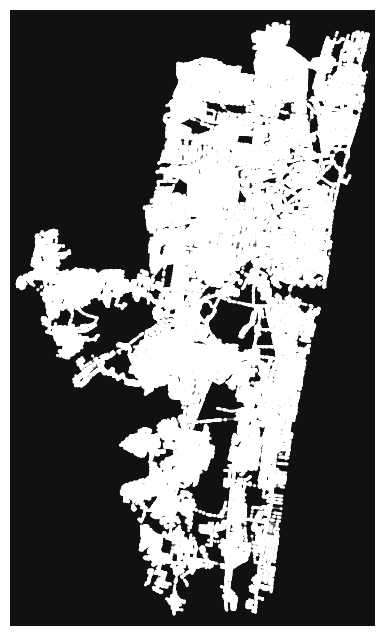

In [ ]:
place = "Chennai, Tamil Nadu, India"
place_geocode_gdf = ox.geocode_to_gdf(place, which_result=2)
geometry = place_geocode_gdf.geometry.iloc[0]
if geometry.geom_type in ['Polygon', 'MultiPolygon']:
    G = ox.graph_from_polygon(geometry, network_type='drive', simplify=False)
    G_undirected = G.to_undirected()
    ox.plot_graph(G_undirected, node_size=5, edge_color='gray')
else:
    print("The specified place does not have polygon geometry.")


In [22]:
place_nodes = ox.graph_to_gdfs(G_undirected, nodes=True, edges=False, node_geometry=True, fill_edge_geometry=False)
place_edges = ox.graph_to_gdfs(G_undirected, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True).drop(columns=['maxspeed', 'lanes', 'ref', 'width', 'bridge','oneway', 'highway', 'access', 'reversed','name'])
place_nodes.drop(columns=['street_count','highway'],inplace=True)

In [ ]:
place_nodes

In [ ]:
place_nodes.explore()

In [ ]:
node_df = place_nodes.drop(columns=['junction', 'railway', 'ref'])
node_df

- Choose a random start node based on initial node popularity
- Randomly sample trip distance 'l' from Log-Normal distribution
- Find a random end node with the 'l' as the shortest distance from the start node
- Update the node vists and node popularity

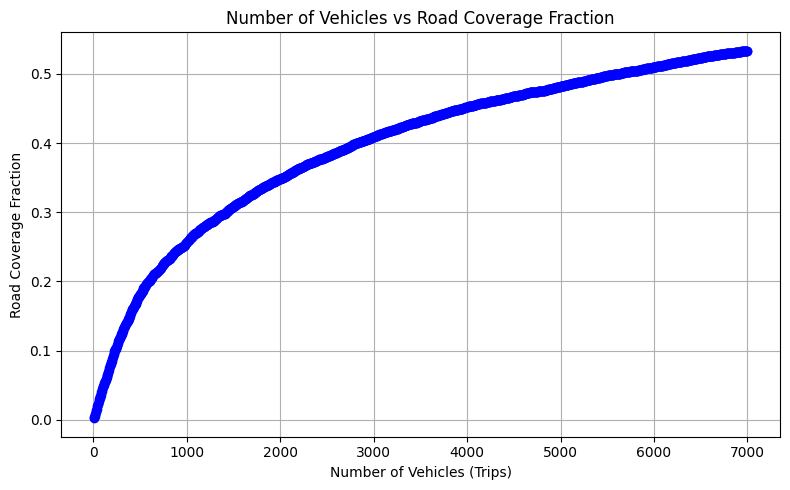

Vehicles needed to reach road coverage thresholds:
  10% coverage → 230 vehicles
  30% coverage → 1420 vehicles
  50% coverage → 5615 vehicles
  80% coverage → Not reached


In [36]:

# Reset node and edge stats
node_df['visits'] = 0
node_df['popularity'] = np.random.rand(len(node_df)) + 1e-6
node_df['popularity'] /= node_df['popularity'].sum()

edge_df = place_edges.copy()
edge_df["visits"] = 0
total_edges = len(edge_df)

# --- Helpers ---
def normalize_popularity(df):
    df['popularity'] += 1e-6
    df['popularity'] /= df['popularity'].sum()
    return df

def sample_start_node():
    return np.random.choice(node_df.index, p=node_df["popularity"].values)

def sample_trip_distance(mu_log_meters=np.log(3000), sigma=0.5):
    return np.random.lognormal(mean=mu_log_meters, sigma=sigma)

def find_destination_node(G, start_node, target_length, tolerance=50):
    try:
        lengths = nx.single_source_dijkstra_path_length(G, start_node, weight='length', cutoff=target_length + tolerance)
        candidates = [node for node, dist in lengths.items() if abs(dist - target_length) <= tolerance]
        if candidates:
            return np.random.choice(candidates)
    except:
        pass
    return None

def update_nodes_along_path(path_nodes):
    for node in path_nodes:
        node_df.at[node, 'visits'] += 1
        node_df.at[node, 'popularity'] += 0.01
    normalize_popularity(node_df)

def update_edge_visits(path, visited_edges_set):
    for u, v in zip(path[:-1], path[1:]):
        for direction in [(u, v), (v, u)]:
            matches = edge_df.loc[
                (edge_df.index.get_level_values(0) == direction[0]) &
                (edge_df.index.get_level_values(1) == direction[1])
            ]
            for idx in matches.index:
                edge_df.at[idx, "visits"] += 1
                visited_edges_set.add(idx)

def simulate_trip():
    start = sample_start_node()
    l = sample_trip_distance()
    end = find_destination_node(G_undirected, start, l)
    if end and start != end:
        try:
            path = nx.shortest_path(G_undirected, start, end, weight='length')
            update_nodes_along_path(path)
            return path
        except nx.NetworkXNoPath:
            return None
    return None

# --- Main Simulation ---
# User input
num_vehicles = int(input("Enter the number of vehicles to simulate: "))

vehicle_counts = []
road_coverage_fractions = []
visited_edges = set()

checkpoint_interval = 5

for i in range(1, num_vehicles + 1):
    path = simulate_trip()
    if path:
        update_edge_visits(path, visited_edges)

    if i % checkpoint_interval == 0:
        vehicle_counts.append(i)
        road_coverage_fractions.append(len(visited_edges) / total_edges)

# --- Plotting ---
plt.figure(figsize=(8, 5))
plt.plot(vehicle_counts, road_coverage_fractions, marker='o', color='blue')
plt.title("Number of Vehicles vs Road Coverage Fraction")
plt.xlabel("Number of Vehicles (Trips)")
plt.ylabel("Road Coverage Fraction")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Threshold Reporting ---
coverage_thresholds = [0.1, 0.3, 0.5, 0.8]
threshold_hits = {}

for threshold in coverage_thresholds:
    for vehicles, coverage in zip(vehicle_counts, road_coverage_fractions):
        if coverage >= threshold:
            threshold_hits[threshold] = vehicles
            break

print("Vehicles needed to reach road coverage thresholds:")
for threshold in coverage_thresholds:
    if threshold in threshold_hits:
        print(f"  {int(threshold * 100)}% coverage → {threshold_hits[threshold]} vehicles")
    else:
        print(f"  {int(threshold * 100)}% coverage → Not reached")
